In [1]:
#import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid', context='notebook', palette='deep') 
import matplotlib.style as style
style.use('fivethirtyeight')
import scipy
from scipy import stats

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train_org=train.copy()
test_org=test.copy()

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
data=train.copy()
data.info()
# it is a classification problem
# we have nan-values in Age and Cabin variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
print('Number of unique passenger IDs {}'. format(len(train['PassengerId'].unique())))
#passenger ID is unique for each person, so it is possible to use it as index
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)
data.set_index('PassengerId', inplace=True)

Number of unique passenger IDs 891


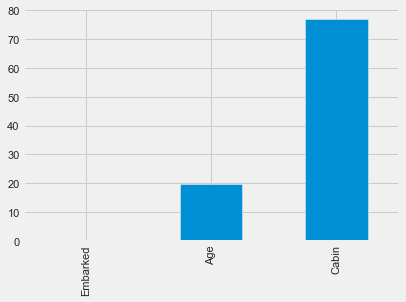

In [6]:
missing=data.isnull().sum()
missing=(missing[missing>0]*100/len(train)).sort_values()
missing.plot(kind='bar')
plt.show()
# roughly 80 percent of data for cabin is missing! we may drop this feature later, however, further investigation is required

# Univariate and Bivariate Analysis

In [7]:
#target=train['Survived']
#train=train.iloc[:, 1:]
features=data.columns
num=[f for f in train.columns if train[f].dtype!='O']
cat=[f for f in train.columns if train[f].dtype=='O']

def unique(frame, feature):
    print('number of unique values for {}: {} {}'.format(feature, len(frame[feature].unique()), frame[feature].dtype))
for feature in features:
    unique(data, feature)
# Pclass is numerical, however by having 3 unique values it seems representing categories
# SibSp, and Parch are ordinal values representing number of sibilings, spouse, parents and children

number of unique values for Survived: 2 int64
number of unique values for Pclass: 3 int64
number of unique values for Name: 891 object
number of unique values for Sex: 2 object
number of unique values for Age: 89 float64
number of unique values for SibSp: 7 int64
number of unique values for Parch: 7 int64
number of unique values for Ticket: 681 object
number of unique values for Fare: 248 float64
number of unique values for Cabin: 148 object
number of unique values for Embarked: 4 object


In [8]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')  
titles=data['Title'].value_counts()
titles=titles[titles<40].keys().tolist()
for title in titles:
    data['Title']=data['Title'].replace(title, 'Rare')
    
data['Deck']=data['Cabin'].apply(lambda x: str(x)[:1])

data['Cabin_num']=data['Cabin'].apply(lambda x: str(x)[1:])
data['Cabin_num']=data['Cabin_num'].replace('an', 'NaN')
data['Cabin_num']=data['Cabin_num'].astype(str)
data['Cabin_num']=data['Cabin_num'].apply(lambda x: str([int(s) for s in x.split() if s.isdigit()])[1:-1])
data['Cabin_num'].replace('', np.nan, inplace=True)
data['Cabin_num']=data['Cabin_num'].astype(float)
def even_odd(x):
    if (x%2)==0:
        return 'Even'
    else:
        return 'Odd'
data['Cabin_na']=np.where(np.isnan(data['Cabin_num']), 1, 0)
data['Cabin_even_odd']=data['Cabin_num'].apply(lambda x: even_odd(x))
data.loc[data['Cabin_na']==1, ['Cabin_even_odd']]=data.loc[data['Cabin_na']==1, ['Cabin_even_odd']]=np.nan


data['Ticket_num']=data['Ticket'].apply(lambda x: str([int(s) for s in x.split() if s.isdigit()])[1:2])
data['Ticket_num'].replace(']', 'na', inplace=True)
rare=data['Ticket_num'].value_counts()
rare=rare[rare<20].keys().tolist()
for num in rare:
    data['Ticket_num']=data['Ticket_num'].replace(rare, 'Rare')

features=data.columns

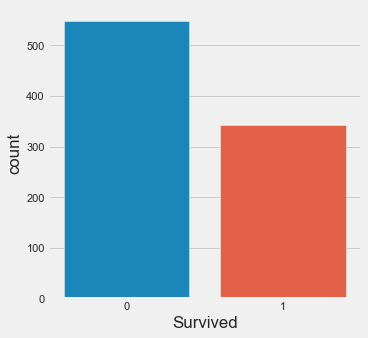

In [10]:
plt.figure(1, figsize=(5,5))
sns.countplot(data['Survived'])
plt.show()
# more than half of the passengers survived.(imbalanced calssification)

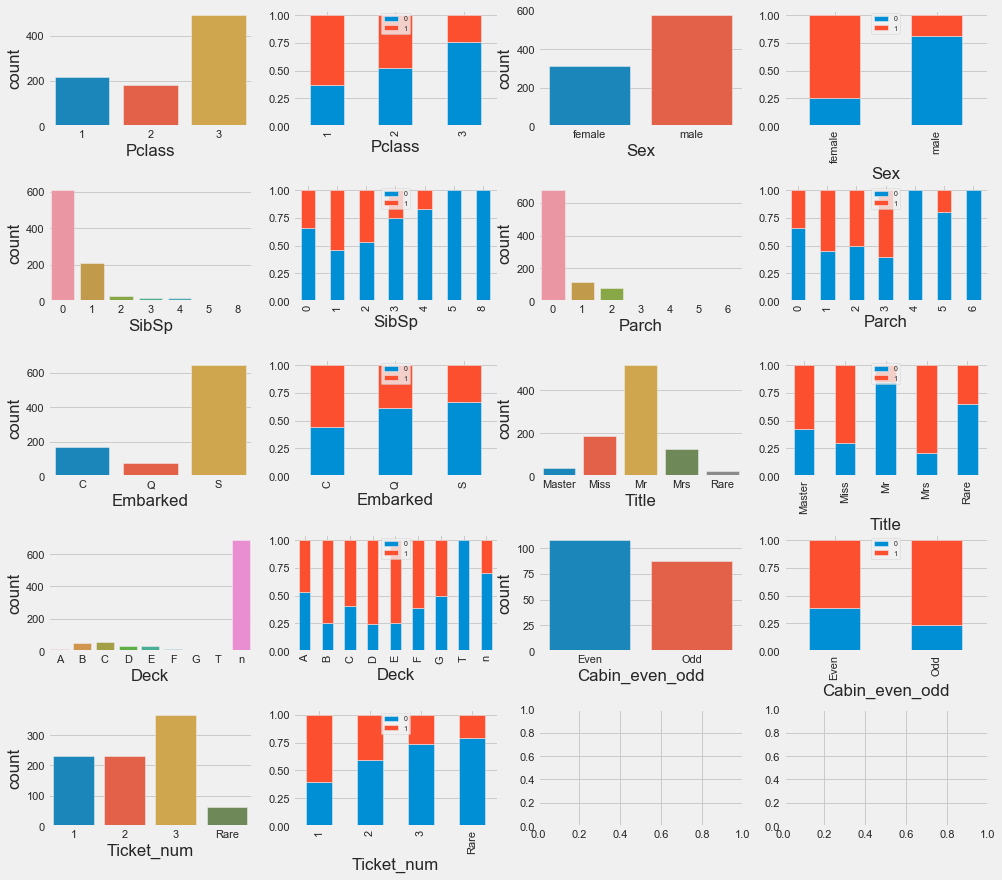

In [11]:
data.drop(['Cabin_num','Cabin_na'], axis=1, inplace=True)
cat_feat=[f for f in data.columns if len(data[f].unique())<11 and f not in ['Survived']]
f, axs= plt.subplots(5, 4, figsize=(15, 14), squeeze=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
axs=axs.flatten()
i=0
for feature in cat_feat:
    
    ax=axs[i]
    sns.countplot(data[feature].sort_values(), ax=ax)
    
    i=i+1
    tab=pd.crosstab(data[feature], data['Survived']).div(pd.crosstab(data[feature], data['Survived'])
                                                           .sum(1).astype(float), axis=0)
    tab.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].legend(loc='upper center', prop={'size':7})
    i=i+1
# most Tickets, were 3rd class, however most people having this ticket didn't survived.
# most people aboard, were men, however most gender survived were females
# most of them doesn't have any sibiling or spouse with them, surviving pattern doesn't represent a clear insight, however, we
# know half of those with one sibilig or spouse survived.
# most of them doesn't have any parents or children with them, surviving pattern doesn't represent a clear insight
# most of them embarked on Southampton followed by Cherbourg and only a small proportion were from Queenstwon, and most of them 
# embarked on Cherbourg survived.
# most titles were Mr, however, nearly 17% of them survived. Mrs and Miss Survived the most.
# most ticket numbers had been sold, starts with 3, however, most survived are those with tickets start with 1.
# people with odd cabin number survived more!! you can find out the reason by googling it.

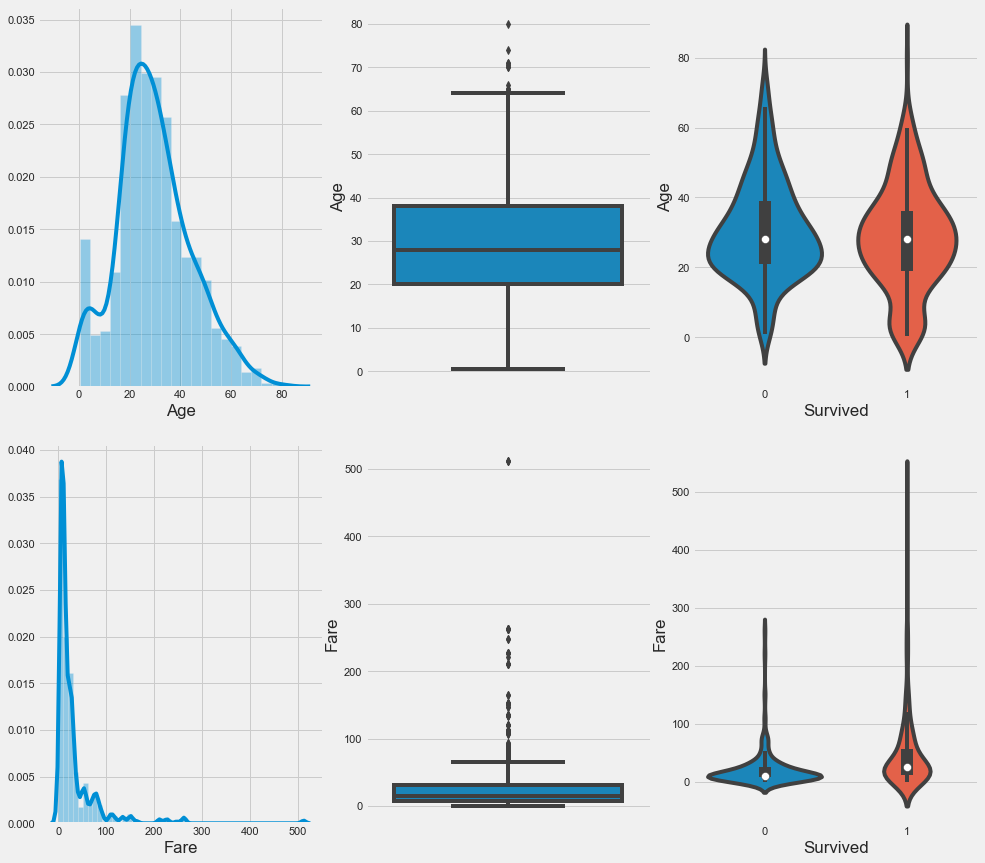

In [12]:
num_feat=['Age', 'Fare']
f, axs= plt.subplots(2,3, figsize=(15, 14), squeeze=False, gridspec_kw={'hspace': 0.15, 'wspace': 0.15})
axs=axs.flatten()
i=0
for feature in num_feat:
    ax=axs[i]
    sns.distplot(data[feature], ax=ax)
    i=i+1
    sns.boxplot(y=feature,data=data, ax=axs[i])
    i=i+1
    sns.violinplot(y=feature, x='Survived', data=data, ax=axs[i])
    i=i+1
# Age follows nearly a gaussian distribution, while having few outliers
# Those survived the most are roughly 30 years and less than 5 years
# Fare distribution is positively skewed with the existance of some outliers at the right.
# The average Fare price of survivors is slightly higher than those who did not survived.

In [13]:
def Ctab(frame, X_feature, Y_feature):
    tab=pd.crosstab(frame[X_feature], frame[Y_feature]).div(pd.crosstab(frame[X_feature], frame[Y_feature]).sum(1), axis=0)
    return tab
def Group(frame, X_feature, Y_feature, np_function ):
    tab=frame.groupby([X_feature]).agg({Y_feature:np_function})
    return tab

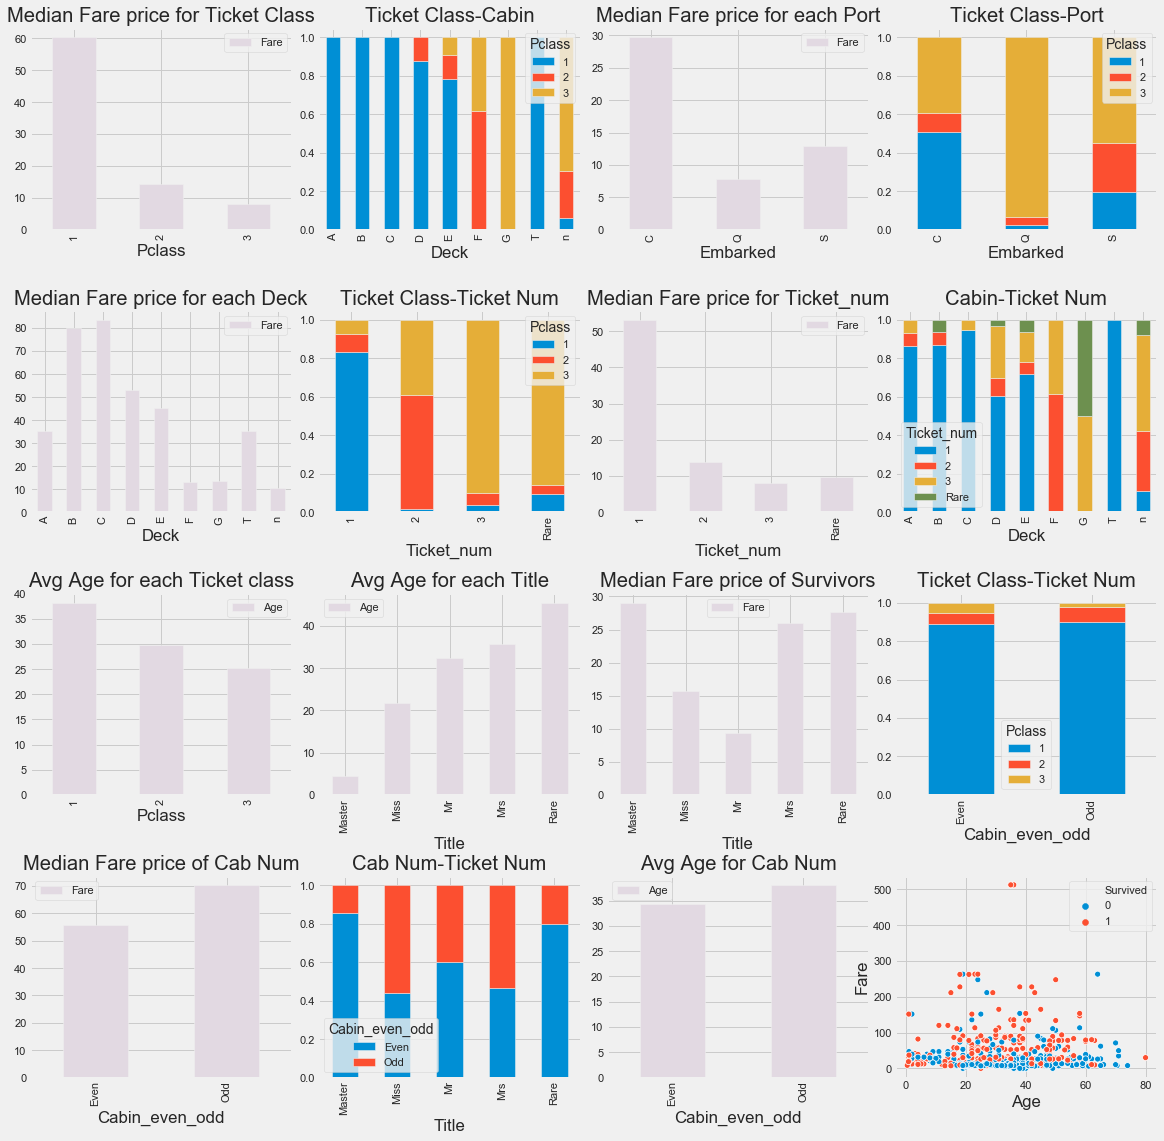

In [14]:
# we can look at the relationship between independent variables and multivariables as well to find interesting insights.
f, axs= plt.subplots(4, 4, figsize=(18, 18), squeeze=False, gridspec_kw={'hspace':0.4, 'wspace':0.1})
axs=axs.flatten()
#ax=axs[i]
Group(data, 'Pclass', 'Fare', np.median).plot(kind='bar', title='Median Fare price for Ticket Class', ax=axs[0], cmap='twilight')
Ctab(data, 'Deck', 'Pclass').plot(kind='bar', stacked=True, title='Ticket Class-Cabin', ax=axs[1])
Group(data, 'Embarked', 'Fare', np.median).plot(kind='bar', title='Median Fare price for each Port', ax=axs[2], cmap='twilight') 
Ctab(data, 'Embarked', 'Pclass').plot(kind='bar', stacked=True, title='Ticket Class-Port', ax=axs[3])
Group(data, 'Deck', 'Fare', np.median).plot(kind='bar', title='Median Fare price for each Deck', ax=axs[4], cmap='twilight')
Ctab(data, 'Ticket_num', 'Pclass').plot(kind='bar', stacked=True, title='Ticket Class-Ticket Num', ax=axs[5])
Group(data, 'Ticket_num', 'Fare', np.median).plot(kind='bar', title='Median Fare price for Ticket_num', ax=axs[6], cmap='twilight')
Ctab(data, 'Deck', 'Ticket_num').plot(kind='bar', stacked=True, title='Cabin-Ticket Num', ax=axs[7])
Group(data,'Pclass', 'Age', np.mean).plot(kind='bar', title='Avg Age for each Ticket class', ax=axs[8], cmap='twilight')
Group(data, 'Title', 'Age', np.mean).plot(kind='bar', title='Avg Age for each Title', ax=axs[9], cmap='twilight')
Group(data, 'Title', 'Fare', np.median).plot(kind='bar', title='Median Fare price of Survivors', ax=axs[10], cmap='twilight')
Ctab(data, 'Cabin_even_odd', 'Pclass').plot(kind='bar', stacked=True, title='Ticket Class-Ticket Num', ax=axs[11])
Group(data, 'Cabin_even_odd', 'Fare', np.median).plot(kind='bar', title='Median Fare price of Cab Num', ax=axs[12], cmap='twilight')
Ctab(data, 'Title', 'Cabin_even_odd').plot(kind='bar', stacked=True, title='Cab Num-Ticket Num', ax=axs[13])
Group(data, 'Cabin_even_odd', 'Age', np.mean).plot(kind='bar', title='Avg Age for Cab Num', ax=axs[14], cmap='twilight')
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data, ax=axs[15])
plt.show()
# median fare price is increasing with the ticket class
# it seems Cabin A, B, C is fully accupied with first class ticket, while others is a combination of different classes, except G 
# which is dedicated to 3rd class, also median fare price is significantly higher for Deck B & C
# People boarded on Cherbourg paid a significant higher amount compare to the two other ports & it is obvious from
# Ticket class-Port plot that half most 1st class tickets has been sold in Cherbourg, while many more than 90% of tickets have
# been issued in Queenstown are 3rd class.
# by looking at Ticket Class-Ticket Num, it seems most tickets started with 1 allocated to 1st class, 2 allocated to 2nd and 3rd
# class, and 3 mostly allocated to 3rd class. also the fare price for tickets started with 1 is significantly higher than the 
# others.
# the bar plot for Ticket_num-cabin is very similar to Ticket Class-Cabin.
# it seems the avg age Age of people with First class tickets is significantly higher than the others.
# master is a way of addressing politely a young boy, so we can also see the avg age for each title.
# it seems tickets were not half price or cheaper for young children as we can seen master has a high median fare price and
# people with Mr, title had paid the least.
# median fare price of tickets for cabins with odd number is higher, and avg age for cabins with odd number is higher as well.
# people with 3 class tickets have been settled in even cabins slightly more than odd cabins.
# Finally, we can see in the scatter plot that more people with high fare price survived than those with cheap tickets.


In [15]:
def Factor(frame, X_feature, Hue_feature, Col_feature, Y_feature, np_function):
    tab=frame.groupby([X_feature, Hue_feature, Col_feature]).agg({Y_feature:np_function}).reset_index()
    plot=sns.factorplot(x= X_feature, hue= Hue_feature, col= Col_feature, y= Y_feature, data=tab, kind='bar')
    return plot

In [16]:
#We can investigate the relationship between three categorical features and one numerical for all the available variables
# Important Note: implementing below code might give us a deeper understanding of the whole data set and relation between 
# various variables, it is not recommended, though, since it will return a huge number of factor plots, whcih is computationally
# heavy and it is extremely time consuming to investigate each plot to extract any potential insight.

import itertools
comb=itertools.combinations(cat_feat, 2)
#for feature in comb:
        #Factor(data, feature[0], feature[1], 'Survived', 'Fare', np.median)
        #Factor(data, feature[0], feature[1], 'Survived', 'Age', np.mean)
        #plt.show()
       
        
#Factor(data, 'Pclass', 'Sex', 'Survived', 'Fare', np.median)
#Factor(data, 'Pclass', 'Sex', 'Survived', 'Age', np.mean)
#plt.show()

## it might be useful to apply label encoding for categorical features and then investigate the correlation between various variables using a correlation matrix.


In [17]:

from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
lab_lst=['Sex', 'Cabin', 'Embarked', 'Title', 'Ticket_num', 'Cabin_even_odd']
for feature in lab_lst:
    data[feature]=data[feature].astype(str)
    data[feature+'_lab']=label.fit_transform(data[feature])

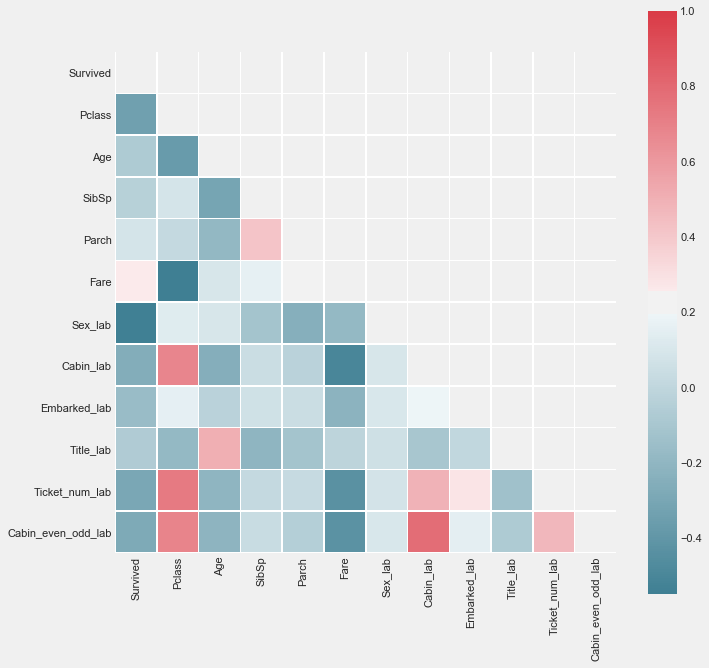

In [18]:
plt.figure(1, figsize=(10,10))
corr_matrix=data.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix,mask=mask, 
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.show()
# we can clearily see that Pclass and Sex_lab has a significant negative correlation with survived, that means
# people with 1st class and female passengers had a better chance to survive.
# Ticket_num_lab and Cabin_lab has a significant possitive correlation with Pclass, that means most of ticket numbers starting
# with 1 had been issued for first class tickets and tickets with higher class tend to settle in higher decks such as B and C
# Fare has a significant negative correlation with Cabin_lab and Ticket_num, that means those who had ticket numbers starting
# with 3 and setteling in lower decks such as F and G had bought cheaper tickets.

## Final Assumption:
### it seems sex and ticket class play important roles in chance of being survived
### clearly people who had been paid more for their tickets(Fare), had been settled in higher decks(Cabin_lab), which might be a reason why they survived more, since higher decks had much faster access to the highest deck which life boats where located, plus, being a woman could increase the chance of surviving significantly, I assume there was a priority to board women and children first on life boats.

# Data Munging

## missing value imputation & feature creation

### Note: to impute the missing values, first I need to create a number of new features:

In [19]:
# the original dataset doesn't have a title feature, hence we should create it first.
# feature creation
def title_crt(frame):   
    frame['Title'] = frame['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    frame['Title'] = frame['Title'].replace('Mlle', 'Miss')
    frame['Title'] = frame['Title'].replace('Ms', 'Miss')
    frame['Title'] = frame['Title'].replace('Mme', 'Mrs')  
    titles=frame['Title'].value_counts()
    titles=titles[titles<40].keys().tolist()
    for title in titles:
        frame['Title']=frame['Title'].replace(title, 'Rare')

In [20]:
# During the EDA we've seen that setteling on some decks drastically decreased the chance of being survided, however, cabin has 
# many missing values but we have seen in correlation matrix that ticket class(Pclass), and the amount of fare price, are highly
# correlated with this variable, hence I am going to impute the missing values with the help of these two variables. but we need
# to creat the deck variable first
train['Deck']=train['Cabin'].apply(lambda x: str(x)[:1])
train['Deck'].replace('n', np.nan, inplace=True)
test['Deck']=test['Cabin'].apply(lambda x: str(x)[:1])
test['Deck'].replace('n', np.nan, inplace=True)

In [21]:
def ticket_num_crt(frame):
    frame['Ticket_num']=frame['Ticket'].apply(lambda x: str([int(s) for s in x.split() if s.isdigit()])[1:2])
    frame['Ticket_num'].replace(']', 'na', inplace=True)
    rare=frame['Ticket_num'].value_counts()
    rare=rare[rare<20].keys().tolist()
    for num in rare:
        frame['Ticket_num']=frame['Ticket_num'].replace(rare, 'Rare')

In [22]:
def fare_bin_crt(frame):
    labels=['Low', 'Low_Mid', 'Up_Mid', 'High']
    frame['Fare_bin']=pd.qcut(frame['Fare'], 4, labels=labels)

In [23]:
# missing value imputation
def age_emb_imp(frame):
    frame['Age']=frame['Age'].astype(float)
    frame['Age']=frame['Age'].fillna(frame.groupby(['Title', 'SibSp'])['Age'].transform('mean'))
    frame['Embarked']=frame['Embarked'].fillna(frame['Embarked'].mode()[0])

In [24]:
def alone_crt(frame):
    frame['Alone']=frame['SibSp'].astype(int)+frame['Parch'].astype(int)
    frame['Alone']=np.where(frame['Alone']==int(0), 'Alone', 'Not Alone')

In [25]:
def agebin(x):
    if 0<x<=3:
        return 'Infant/Toddler'
    elif 3<x<=5:
        return 'Young Child'
    elif 5<x<=13:
        return 'Child'
    elif 13<x<=17:
        return 'Teenager'
    elif 17<x<=35:
        return 'Adult'
    elif 35<x<=60:
        return 'Middle Age'
    elif x>60 :
        return 'Elderly'
def agebin_crt(frame):
    frame['Age_bin']=frame['Age'].apply(lambda x: agebin(x))
    frame['Age_bin']=frame['Age_bin'].fillna(frame['Age_bin'].mode()[0])

In [26]:
def sextie_crt(frame):
    frame['Sex_Tie']=frame['Sex']+' '+frame['Alone']

In [27]:
def sexage_crt(frame):
    frame['Sex_Age']=frame['Sex']+' '+frame['Age_bin']

In [28]:
# I'm going to impute the missing values of Deck with the help of groupby. below code while grouping data based on
# Pclass and Fare_bin, try to find the mode for Deck and then impute missing values of that specified group with the
# the most frequent Deck.
# Note: later we can compare the prediction of two models with and without this new feature to understand whether it is useful.
def deck_imp(frame): 
    A=train.groupby(['Pclass', 'Fare_bin'])['Deck'].value_counts()
    A=pd.DataFrame(A)
    A.columns=['Deck_count']
    A=A.reset_index()

    Pclass_lst=A['Pclass'].unique().tolist()
    Fare_bin_lst=A['Fare_bin'].unique().tolist()
    lst=[]

    import itertools
    for r in itertools.product(Pclass_lst, Fare_bin_lst):
        lst.append(r)
    lst=list(set(lst))
    lst=sorted(lst)
    del lst[2]
    del lst[4]
    del lst[6]
    a=[]

    for r in lst:
            item=A.loc[(A['Pclass']==int(r[0]))&(A['Fare_bin']==str(r[1])), ['Deck', 'Deck_count']].sort_values('Deck_count',
                                                                                                     ascending=False).iloc[0, 0]
            frame.loc[(frame['Pclass']==int(r[0]))&(frame['Fare_bin']==str(r[1])), ['Deck']
                     ]=frame.loc[(frame['Pclass']==int(r[0]))&(frame['Fare_bin']==str
                                                               (r[1])), ['Deck']].fillna(str(item), axis=0)

    frame.loc[(frame['Pclass']==int(3))&(frame['Fare_bin']=='High'), ['Deck']
                     ]=frame.loc[(frame['Pclass']==int(3))&(frame['Fare_bin']=='High'), ['Deck']].fillna('G')
    frame.loc[(frame['Pclass']==int(2))&(frame['Fare_bin']=='Low'), ['Deck']
                     ]=frame.loc[(frame['Pclass']==int(2))&(frame['Fare_bin']=='Low'), ['Deck']].fillna('D')

In [29]:
title_crt(train)
title_crt(test)

age_emb_imp(train)
age_emb_imp(test)
# there is also missing values in Fare variable for test dataset
test['Fare']=test.Fare.fillna(test.groupby(['Pclass', 'Embarked'])['Fare'].transform('median'))

ticket_num_crt(train)
ticket_num_crt(test)

fare_bin_crt(train)
fare_bin_crt(test)

deck_imp(train)
deck_imp(test)

alone_crt(train)
alone_crt(test)

agebin_crt(train)
agebin_crt(test)

sextie_crt(train)
sextie_crt(test)

sexage_crt(train)
sexage_crt(test)

train.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

train.shape, test.shape

((891, 16), (418, 15))

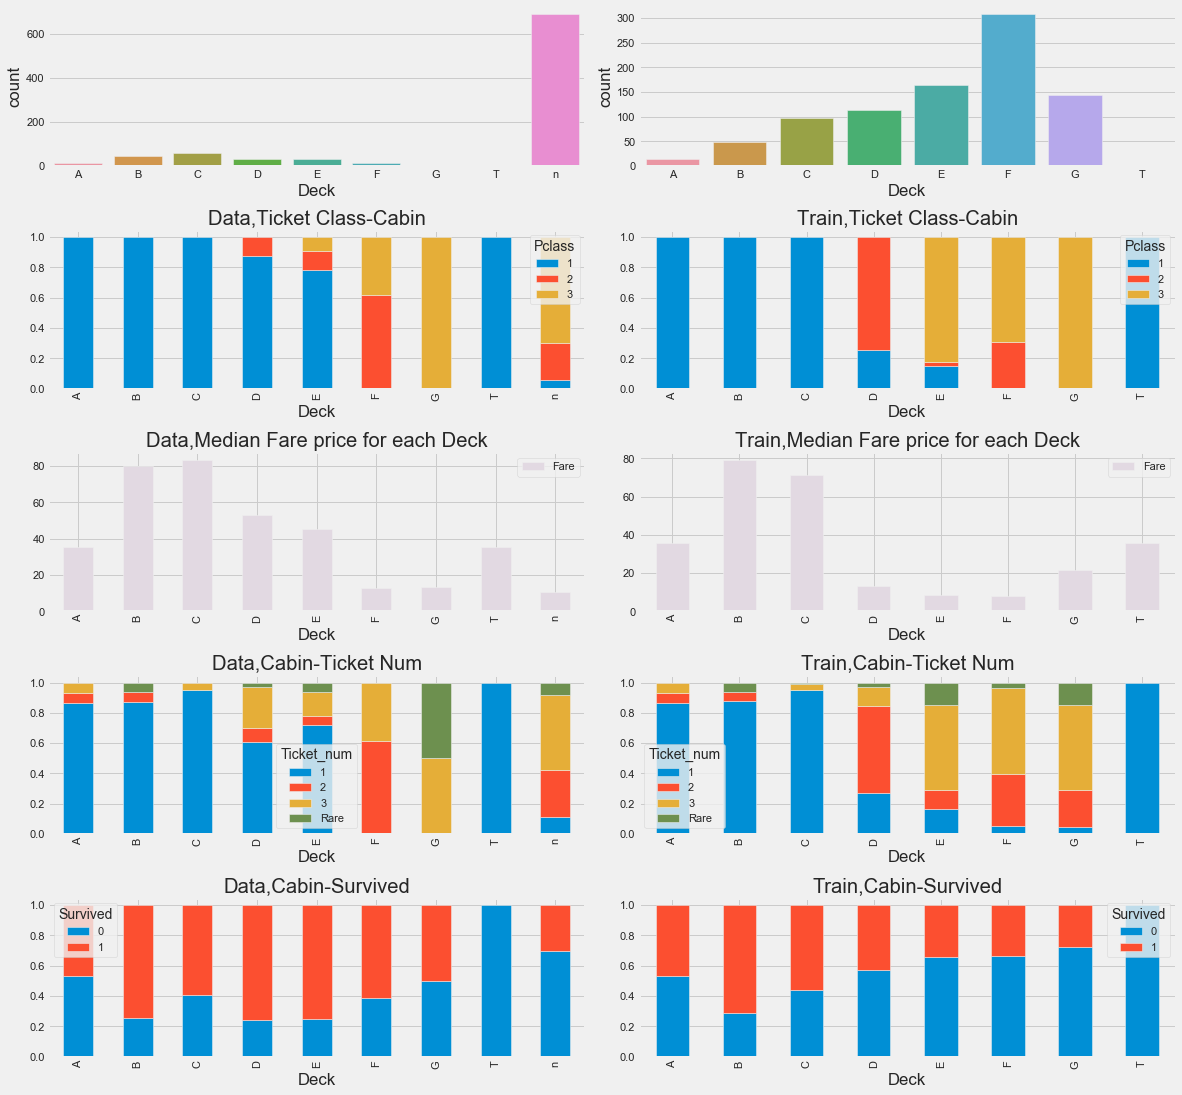

In [30]:
# since nearly 80% of data was missing for cabin feature I visualize the data before and after the imputation to understand better
# the impact of this imputation on my whole dataset.
f, axs= plt.subplots(5, 2, figsize=(18, 18), squeeze=False, gridspec_kw={'hspace':0.4, 'wspace':0.1})
axs=axs.flatten()
sns.countplot(data['Deck'].sort_values(), ax=axs[0])
sns.countplot(train['Deck'].sort_values(), ax=axs[1])
Ctab(data, 'Deck', 'Pclass').plot(kind='bar', stacked=True, title='Data,Ticket Class-Cabin',ax=axs[2])
Ctab(train, 'Deck', 'Pclass').plot(kind='bar', stacked=True, title='Train,Ticket Class-Cabin',ax=axs[3])
Group(data, 'Deck', 'Fare', np.median).plot(kind='bar', title='Data,Median Fare price for each Deck', cmap='twilight', ax=axs[4])
Group(train, 'Deck', 'Fare', np.median).plot(kind='bar', title='Train,Median Fare price for each Deck', cmap='twilight', ax=axs[5])
Ctab(data, 'Deck', 'Ticket_num').plot(kind='bar', stacked=True, title='Data,Cabin-Ticket Num', ax=axs[6])
Ctab(train, 'Deck', 'Ticket_num').plot(kind='bar', stacked=True, title='Train,Cabin-Ticket Num', ax=axs[7])
Ctab(data, 'Deck', 'Survived').plot(kind='bar', stacked=True, title='Data,Cabin-Survived', ax=axs[8])
Ctab(train, 'Deck', 'Survived').plot(kind='bar', stacked=True, title='Train,Cabin-Survived', ax=axs[9])

plt.show()

# Data transformation & Preprocessing

## Encoding Categorical features
### Label encoding

In [31]:
train['Ticket_num'].replace('Rare', 3, inplace=True)
test['Ticket_num'].replace('Rare', 3, inplace=True)
train['Ticket_num']=train['Ticket_num'].astype('int64')
test['Ticket_num']=test['Ticket_num'].astype('int64')
train['Fare_bin']=train['Fare_bin'].astype('O')
test['Fare_bin']=test['Fare_bin'].astype('O')
cat_features=[f for f in train.columns if train[f].dtype=='O']
lab_lst=[]
for f in cat_features:
    if len(train[f].unique())>3:
        print('feature {} has {} unique values'.format(f, len(train[f].unique())))
        lab_lst.append(f)
    else:
        pass

feature Deck has 8 unique values
feature Title has 5 unique values
feature Fare_bin has 4 unique values
feature Age_bin has 7 unique values
feature Sex_Tie has 4 unique values
feature Sex_Age has 14 unique values


In [32]:
#label-encoding (ordinal encoding using values of another feature)
def lab_encoder(train_frame, test_frame, feature, order, func):
    ordering = pd.DataFrame()
    ordering['val'] = train_frame[feature].unique()
    ordering.index = ordering.val
    ordering['Avg'] = train_frame[[feature, order]].groupby(feature).agg({order:func})
    ordering = ordering.sort_values('Avg')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    print(feature+'_lab :',ordering,'\n')
    
    for cat, cat_order in ordering.items():
        train_frame.loc[train_frame[feature] == cat, feature+'_lab'] = cat_order
        test_frame.loc[test_frame[feature] == cat, feature+'_lab'] = cat_order
    # or >>>> frame[feature+'_E']=frame[feature].map(ordering)


In [33]:
# the order of below features is Age-dependent, while the order of two other features is fare-dependent
lab_lst1=['Title', 'Age_bin', 'Sex_Age']
for feature in lab_lst1:  
    lab_encoder(train, test, feature, 'Age', np.mean)
    

Title_lab : {'Master': 1, 'Miss': 2, 'Mr': 3, 'Mrs': 4, 'Rare': 5} 

Age_bin_lab : {'Infant/Toddler': 1, 'Young Child': 2, 'Child': 3, 'Teenager': 4, 'Adult': 5, 'Middle Age': 6, 'Elderly': 7} 

Sex_Age_lab : {'male Infant/Toddler': 1, 'female Infant/Toddler': 2, 'male Young Child': 3, 'female Young Child': 4, 'male Child': 5, 'female Child': 6, 'female Teenager': 7, 'male Teenager': 8, 'female Adult': 9, 'male Adult': 10, 'female Middle Age': 11, 'male Middle Age': 12, 'female Elderly': 13, 'male Elderly': 14} 



In [34]:
lab_lst2=['Deck', 'Fare_bin']
for feature in lab_lst2:
    lab_encoder(train, test, feature, 'Fare', np.median)

Deck_lab : {'F': 1, 'E': 2, 'D': 3, 'G': 4, 'A': 5, 'T': 6, 'C': 7, 'B': 8} 

Fare_bin_lab : {'Low': 1, 'Low_Mid': 2, 'Up_Mid': 3, 'High': 4} 



### One Hot Encoding
#### the rest of categorical features are not ordinal and they have less than 5 unique values, therefore we can use get_dummies function to transform them

In [35]:
lab_lst=list(set(lab_lst1+lab_lst2))
cat_features=[f for f in train.columns if train[f].dtype=='O']
ohe_lst=[f for f in cat_features if f not in lab_lst]
print(ohe_lst), print(lab_lst)

['Sex', 'Embarked', 'Alone', 'Sex_Tie']
['Deck', 'Fare_bin', 'Age_bin', 'Sex_Age', 'Title']


(None, None)

In [36]:
train_ohe=pd.get_dummies(train[ohe_lst])
test_ohe=pd.get_dummies(test[ohe_lst])

### we've seen during the EDA, both numerical features have outliers and Fare feature is positively skewed, to eliminate those I binned both features, hence it is safe to drop numerical features now 

In [37]:
train.drop(['Age', 'Fare'], axis=1, inplace=True)
test.drop(['Age', 'Fare'], axis=1, inplace=True)

### now it's time to concat transformed features and drop extra columns

In [38]:
extra_feat=list(set(lab_lst+ohe_lst))
train.drop(extra_feat, axis=1, inplace=True)
train=pd.concat([train, train_ohe], axis=1)
test.drop(extra_feat, axis=1, inplace=True)
test=pd.concat([test, test_ohe], axis=1)

# Normalization